In [2]:
from pathlib import Path
import sys

# Add the parent directory to sys.path to import preprocessing.py
sys.path.append(str(Path().resolve().parent / 'src'))

# Variables available_styles, data, data_path, df, df_all, file_path, ticker, tickers are already defined in the notebook.


In [10]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Use the AAPL price series, skip the header if present and convert to float
aapl_series = data['MSFT']['MSFT'].dropna().values[1:].astype(float).reshape(-1, 1)

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(aapl_series)

# Create sequences (e.g., 60 days of history to predict the next day)
sequence_length = 60
X, y = [], []

for i in range(sequence_length, len(scaled_data)):
    X.append(scaled_data[i-sequence_length:i, 0])
    y.append(scaled_data[i, 0])

X, y = np.array(X), np.array(y)

# Reshape input to 3D: [samples, time steps, features]
X = X.reshape((X.shape[0], X.shape[1], 1))


In [11]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))  # Output layer

model.compile(optimizer='adam', loss='mean_squared_error')


c:\Users\GODIWOUR\AppData\Local\anaconda\envs\stock_forecast\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [12]:
history = model.fit(X, y, epochs=10, batch_size=32, verbose=1)


Epoch 1/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0496
Epoch 2/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0023
Epoch 3/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0023
Epoch 4/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0020
Epoch 5/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0020
Epoch 6/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0017
Epoch 7/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0018
Epoch 8/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0017
Epoch 9/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0017
Epoch 10/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0014


In [13]:
# Predict the next 30 days
forecast_days = 30
predictions = []

last_sequence = scaled_data[-sequence_length:]

for _ in range(forecast_days):
    seq_input = last_sequence.reshape(1, sequence_length, 1)
    predicted = model.predict(seq_input)[0][0]
    predictions.append(predicted)
    
    # Append the prediction to the sequence and update
    last_sequence = np.append(last_sequence[1:], [[predicted]], axis=0)

# Inverse transform to get real prices
forecasted_prices = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━

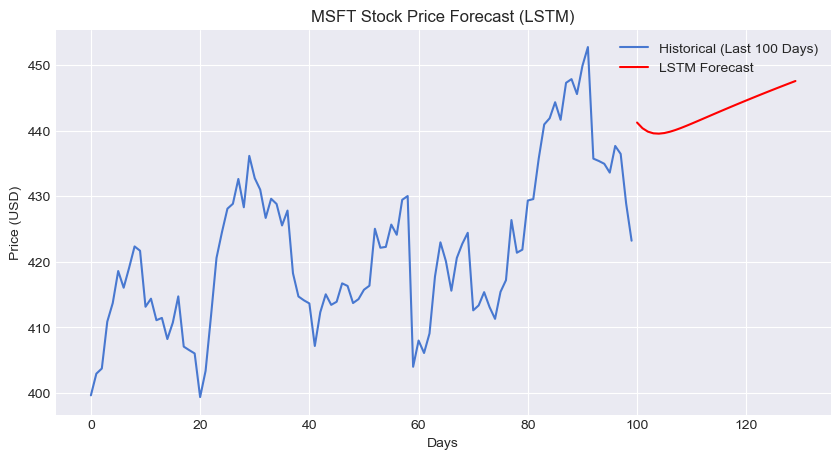

In [14]:
import matplotlib.pyplot as plt

# Plot historical and forecasted prices
plt.figure(figsize=(10, 5))
plt.plot(aapl_series[-100:], label="Historical (Last 100 Days)")
plt.plot(np.arange(100, 100+forecast_days), forecasted_prices, label="LSTM Forecast", color='red')
plt.title("MSFT Stock Price Forecast (LSTM)")
plt.xlabel("Days")
plt.ylabel("Price (USD)")
plt.legend()
plt.show()
